In [1]:
# import warnings
# warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import scipy.sparse as sp
from scipy.sparse import load_npz
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from pathlib import Path

import torch

from cell import utils
from cell.utils import link_prediction_performance, edge_overlap
from cell.cell import Cell, EdgeOverlapCriterion, LinkPredictionCriterion
from cell.graph_statistics import compute_graph_statistics

In [2]:
#train_graph 
_A_obs, _X_obs, _z_obs = utils.load_npz('../data/eps_neighbour_graph.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

Selecting 1 largest connected components


In [3]:
with np.load('../data/eps_neighbour_graph.npz', allow_pickle=True) as loader:
    coos = loader['coos']
    # coos = coos[:, :2]
    coos = coos[lcc, :2]

In [4]:
coos.shape, _A_obs.shape

((246, 2), (246, 246))

In [5]:
print(_N)

246


In [6]:
Gs = dict()
df = pd.DataFrame()

In [7]:
Gs['true'] = _A_obs

In [8]:
val_share = 0.05
test_share = 0.1
seed = 42 #481516234

train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, connected=True, undirected=True, asserts=False)

train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

In [9]:
def run(g_type='cell', loss_fn=None, criterion='eo', nsteps=200, H=3):
    if criterion == 'eo':
        callbacks = [EdgeOverlapCriterion(invoke_every=10, edge_overlap_limit=.5)]
    else:
        callbacks = [LinkPredictionCriterion(invoke_every=2,
                                                val_ones=val_ones,
                                            val_zeros=val_zeros,
                                                max_patience=3)]
    model = Cell(A=train_graph,
             H=H,
             g_type=g_type,
             loss_fn=loss_fn,
             callbacks=callbacks)

    # train model 
    model.train(steps=nsteps,
                optimizer_fn=torch.optim.Adam,
                optimizer_args={'lr': 0.1,
                                'weight_decay': 1e-5})
    
    roc_auc, avg_prec = link_prediction_performance(scores_matrix=model._scores_matrix, val_ones=test_ones, val_zeros=test_zeros)
    print(f'ROC-AUC: {roc_auc}, AVG_PREC: {avg_prec}')

    generated_graphs = [model.sample_graph() for _ in range(5)]
    stats = [compute_graph_statistics(gg) for gg in generated_graphs]
    stat_df = pd.DataFrame({k: [s[k] for s in stats] for k in stats[0].keys()})
    stat_df = stat_df.mean()
    stat_df['roc-auc'] = roc_auc
    stat_df['avg-prec'] = avg_prec

    return stat_df.T, generated_graphs

    

In [10]:
method = 'cell'
options = dict(g_type='cell')

stat_df, generated_graphs = run(**options)
df[method] = stat_df
Gs[method] = generated_graphs[0]

Step:  10/200 Loss: 4.68922 Edge-Overlap: 0.084 Total-Time: 0
Step:  20/200 Loss: 3.78391 Edge-Overlap: 0.275 Total-Time: 0
Step:  30/200 Loss: 3.31409 Edge-Overlap: 0.357 Total-Time: 0
Step:  40/200 Loss: 3.04577 Edge-Overlap: 0.436 Total-Time: 0
Step:  50/200 Loss: 2.87447 Edge-Overlap: 0.497 Total-Time: 1
Step:  60/200 Loss: 2.77641 Edge-Overlap: 0.518 Total-Time: 1
ROC-AUC: 0.9823100936524454, AVG_PREC: 0.9840178785258802


In [11]:
method = 'local cell'
options = dict(g_type='cell', loss_fn='local_cell')

stat_df, generated_graphs = run(**options)
df[method] = stat_df
Gs[method] = generated_graphs[0]

Step:  10/200 Loss: 9.19339 Edge-Overlap: 0.090 Total-Time: 0
Step:  20/200 Loss: 7.44382 Edge-Overlap: 0.271 Total-Time: 0
Step:  30/200 Loss: 6.64378 Edge-Overlap: 0.326 Total-Time: 0
Step:  40/200 Loss: 6.22431 Edge-Overlap: 0.439 Total-Time: 1
Step:  50/200 Loss: 5.99552 Edge-Overlap: 0.464 Total-Time: 1
Step:  60/200 Loss: 5.84413 Edge-Overlap: 0.511 Total-Time: 1
ROC-AUC: 0.9404555439935254, AVG_PREC: 0.9530597694657578


In [12]:
method = 'svd'
options = dict(g_type='svd')

stat_df, generated_graphs = run(**options)
df[method] = stat_df
Gs[method] = generated_graphs[0]

Step:  10/200 Loss: 5.38669 Edge-Overlap: 0.036 Total-Time: 0
Step:  20/200 Loss: 4.33122 Edge-Overlap: 0.265 Total-Time: 0
Step:  30/200 Loss: 3.59201 Edge-Overlap: 0.344 Total-Time: 0
Step:  40/200 Loss: 3.24140 Edge-Overlap: 0.417 Total-Time: 0
Step:  50/200 Loss: 3.05956 Edge-Overlap: 0.468 Total-Time: 1
Step:  60/200 Loss: 2.95506 Edge-Overlap: 0.488 Total-Time: 1
Step:  70/200 Loss: 2.88808 Edge-Overlap: 0.530 Total-Time: 1
ROC-AUC: 0.9788414845646896, AVG_PREC: 0.980218331563194


In [13]:
method = 'local svd'
options = dict(g_type='svd', loss_fn='local_cell')

stat_df, generated_graphs = run(**options)
df[method] = stat_df
Gs[method] = generated_graphs[0]

Step:  10/200 Loss: 10.57403 Edge-Overlap: 0.027 Total-Time: 0
Step:  20/200 Loss: 8.40389 Edge-Overlap: 0.296 Total-Time: 0
Step:  30/200 Loss: 6.93250 Edge-Overlap: 0.355 Total-Time: 0
Step:  40/200 Loss: 6.16103 Edge-Overlap: 0.476 Total-Time: 0
Step:  50/200 Loss: 5.79826 Edge-Overlap: 0.530 Total-Time: 1
ROC-AUC: 0.9750260145681582, AVG_PREC: 0.9755068475459848


In [14]:
method = 'nonlin cell'
options = dict(g_type='fc')

stat_df, generated_graphs = run(**options)
df[method] = stat_df
Gs[method] = generated_graphs[0]

Step:  10/200 Loss: 3.86953 Edge-Overlap: 0.265 Total-Time: 0
Step:  20/200 Loss: 3.13525 Edge-Overlap: 0.431 Total-Time: 0
Step:  30/200 Loss: 2.85303 Edge-Overlap: 0.511 Total-Time: 0
ROC-AUC: 0.9719042663891779, AVG_PREC: 0.9747336847353503


In [15]:
method = 'local nonlin cell'
options = dict(g_type='fc', loss_fn='local_cell')

stat_df, generated_graphs = run(**options)
df[method] = stat_df
Gs[method] = generated_graphs[0]

Step:  10/200 Loss: 8.86616 Edge-Overlap: 0.186 Total-Time: 0
Step:  20/200 Loss: 7.22404 Edge-Overlap: 0.315 Total-Time: 0
Step:  30/200 Loss: 6.46795 Edge-Overlap: 0.377 Total-Time: 0
Step:  40/200 Loss: 6.03646 Edge-Overlap: 0.470 Total-Time: 1
Step:  50/200 Loss: 5.74081 Edge-Overlap: 0.538 Total-Time: 1
ROC-AUC: 0.946814660654411, AVG_PREC: 0.9521683370721247


In [16]:
df['gt'] = list(compute_graph_statistics(_A_obs).values()) + [1, 1]
df

,cell,local cell,svd,local svd,nonlin cell,local nonlin cell,gt
d_max,15.600000,15.800000,15.600000,14.800000,18.200000,21.400000,15.000000
d_min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
d,6.382114,6.382114,6.382114,6.382114,6.382114,6.382114,7.512195
LCC,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
wedge_count,5083.600000,5109.200000,5164.000000,5116.400000,5451.200000,5999.000000,7116.000000
claw_count,11135.200000,11348.800000,11713.400000,11309.800000,13690.400000,18326.800000,18755.000000
triangle_count,521.800000,504.400000,485.000000,483.000000,575.600000,782.800000,1507.000000
square_count,2050.200000,1887.000000,1764.600000,1840.200000,2320.600000,4670.400000,7495.000000
power_law_exp,1.570155,1.570359,1.572635,1.571542,1.583097,1.598832,1.518407
gini,0.231346,0.234257,0.240548,0.236450,0.274410,0.319382,0.222473


No handles with labels found to put in legend.


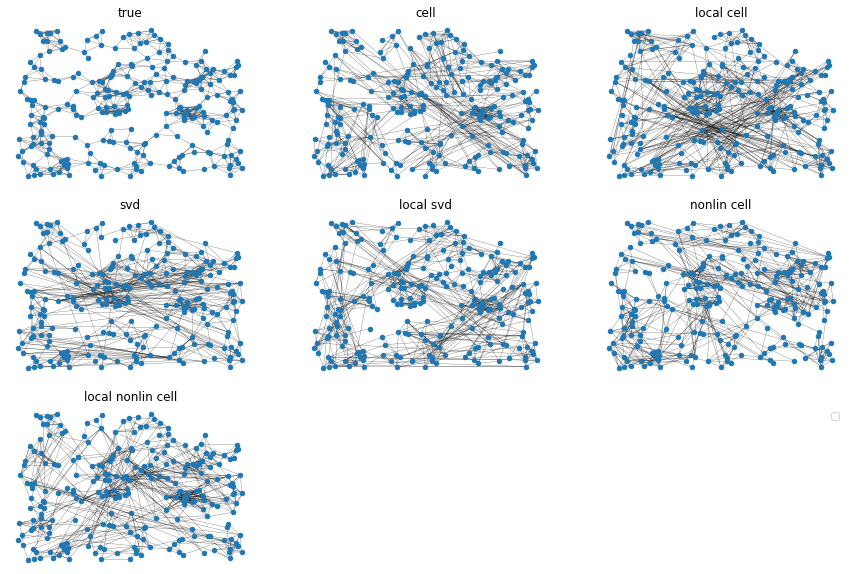

In [17]:
import itertools

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

methods = ['true', 'cell', 'local cell', 'svd', 'local svd', 'nonlin cell', 'local nonlin cell']
for ax, name in zip(itertools.chain.from_iterable(axs), methods):
    G = nx.from_numpy_array(Gs[name].toarray())
    nx.draw(G, node_size=20, width=0.2, pos=coos, ax=ax)
    ax.set_title(name)
for ax in list(itertools.chain.from_iterable(axs))[len(methods):]:
    ax.axis('off')
plt.legend()
plt.savefig('../img/eps_neighbour_graph.png')
plt.show()